Мета роботи: розробка моделі машинного навчання для автоматичної класифікації текстових повідомлень на предмет наявності
ознак військового досвіду на прикладі повідомлень з Telegram-каналів

Актуальність: завдання є актуальним для OSINT-аналізу та пріоритизації інформаційних потоків в реальному часі 


Методологія навчання: для досягнення високої точності було обрано метод ансамблювання двох моделей, що поєднує:
1) Logistic Regression - лінійна модель для виявлення прямих лексичних залежностей
2) Gradient Boosting - складніша модель, яка сама по собі є ансамблевою, дозволяє знаходити складні, нелінійні патерни

В якості метрики оцінки локально для валідації та на змаганні на платформі Kaggle обрано метрику F1-Score як вдалий
баланс між Precision(точністю) та Recall(повнотою)

In [4]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, f1_score
from nltk.stem.snowball import SnowballStemmer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
# Завантаження даних
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('to_answer.csv')

#Заповнення пропусків
train_df['cleaned_message'] = train_df['cleaned_message'].fillna('')
test_df['cleaned_message'] = test_df['cleaned_message'].fillna('')

print(f"Розмір тренувального датасету: {train_df.shape}")
print(f"Розмір тестового датасету: {test_df.shape}")

SPLIT_RANDOM_STATE = 35
MODEL_RANDOM_STATE = 44
print(train_df.head())

Розмір тренувального датасету: (5299, 6)
Розмір тестового датасету: (2271, 7)
                                     cleaned_message  new_label  \
0  💥 Килограммы тротила и языки пламени: с военны...        0.0   
1  Украина призывает кустарно собрать для ВСУ до ...        0.0   
2  В ближайшее время на вооружение ГУР Украины по...        0.0   
3  16.08.2023 Запорожский фронт. Противник продол...        0.0   
4  🔹 Подробнее о ракете Х-101 с ИК-ловушками Неда...        1.0   

                        date                 post_id      channel_name  msg_id  
0  2024-01-19 04:32:41+00:00  inzheneryChMFlot/20679  inzheneryChMFlot   20679  
1  2024-01-16 15:59:33+00:00         anna_news/61296         anna_news   61296  
2  2023-05-14 16:56:32+00:00           dronnitsa/188         dronnitsa     188  
3  2023-08-16 12:59:08+00:00    bpla_instructors/180  bpla_instructors     180  
4  2024-01-02 07:42:12+00:00     binary_glasses/1685    binary_glasses    1685  


В якості препроцесингу використовується спеціальна бібліотека SnowballStemmer для російської мови. Це дозволяє зводити
слова до їх основи(кореня) - це з одного боку зменшує розмірність словника і оптимізує процес навчання, а з іншого - 
покращує узагальнювальну здатність моделі, адже вона краще розуміє логічний сенс та спорідненість слів.
Також застосовується Regex-фільтр(на основі регулярних виразів) для залишення лише кирилииці та латиниці

In [6]:
# Застосування препроцесингу через Snowball Stemmer
stemmer = SnowballStemmer("russian") 

# Функція для препроцесингу через фільтр регулярних виразів 
def clean_and_stem(text):
    text = re.sub(r'[^а-яА-Яa-zA-ZіїєґІЇЄҐ]', ' ', text)
    return " ".join([stemmer.stem(word) for word in text.lower().split()])

#Застосування всього циклу обробки
print("Обробка тексту")
train_df['processed_text'] = train_df['cleaned_message'].apply(clean_and_stem)
test_df['processed_text'] = test_df['cleaned_message'].apply(clean_and_stem)

Обробка тексту


In [7]:
#Ділимо датасет на аргументи та цільову змінну
X = train_df['processed_text']
y = train_df['new_label']
#Проводимо поділ датасету на тренувальний та валідаціний набір в співвдошенні 4:1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SPLIT_RANDOM_STATE, stratify=y)

Далі використовується векторизація(аспект Feature Engineering) через TF-IDF Vectorizer
(Term Frequency - Inverse Document Frequency). Використовується з параметрами:
1) ngram_range = (1,3) - враховуються не тільки окремі слова, а й фрази з 2-3 слів, що дозволяє частково вловлювати
контекст словосполучень та речень
2) max_features = 50000 - обмеження словника найбільш значущими токенами 

In [8]:
#Проводимо векторизацію
print("Векторизація")
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec = tfidf.transform(X_val)

Векторизація


Далі після первинної підготовки даних створюємо ансамбль для навчання, який буде працювати за принципом
голосування(Voting Ensemble). Такий підхід дозволяє компенсувати слабкі сторони однієї моделі сильними сторонами
іншої, зменшуючи загальну дисперсію помилки.

Перша модель - логістична регресія. Логістична регресія була обрана як базовий алгоритм (baseline), оскільки вона
демонструє високу ефективність на розріджених даних високої розмірності (TF-IDF матриці). Вона відмінно знаходить
лінійні залежності між наявністю певних токенів та цільовим класом.
Параметри:
1) C=4.0 - Параметр оберненої регуляризації. Значення 4.0 (що вище за стандартне 1.0) вказує на слабшу регуляризацію.
Це дозволяє моделі сильніше підлаштовуватися під тренувальні дані, що виправдано при великому словнику (50k ознак), де
важливі рідкісні, але "сильні" слова
2) class_weight = "balanced" - Автоматичне балансування ваг класів обернено пропорційно їх частоті. Це критично важливо для максимізації метрики F1, оскільки штраф за помилку на меншості (клас 1) стає вищим.
3) max_iter = 5000 - Збільшена кількість ітерацій солвера. Оскільки матриця ознак дуже велика, стандартних 100
ітерацій часто недостатньо для збіжності градієнтного спуску
4) n_jobs = -1 - використання всіх доступних ядер процесора

In [9]:
clf_lr = LogisticRegression(
    C=4.0, 
    class_weight='balanced', 
    max_iter=5000, 
    random_state=MODEL_RANDOM_STATE,
    n_jobs=-1
)

Друга модель - XgBoost Classifier(Градієнтний бустинг). Градієнтний бустинг використовується для виявлення складних
нелінійних патернів та взаємозв'язків між словами (feature interactions), які не може вловити логістична регресія.
Модель будує ансамбль дерев рішень послідовно, виправляючи помилки попередніх дерев. Параметри:
1) scale_pos_weight=ratio - Cпеціальний параметр для роботи з незбалансованими даними в XGBoost.
    Розрахунок: sum(negative instances) / sum(positive instances).
    Дія: Збільшує вагу градієнта для позитивного класу, змушуючи модель приділяти більше уваги "рідкісним" приклад
    (військовий досвід/загроза).
2) n_estimators = 200 - Кількість дерев в ансамблі. Значення підібрано емпірично як баланс між здатністю до навчання]
та часом тренування.
3) max_depth = 6 - Максимальна глибина одного дерева. Глибина 6 дозволяє моделювати взаємодії між групами слів
(контекст), але запобігає надмірному перенавчанню, яке виникає при глибоких деревах.
4) learning_rate = 0.1 - Швидкість навчання. Стандартне значення, яке забезпечує стабільну збіжність при заданій
кількості дерев
5) n_jobs = -1 - використання всіх доступних ядер процесора
6) eval_metric = "logloss" - метрика оцінки якості під час навчання, використовує Logarithmic Loss - стандартну
функцію втрат для бінарної класифікації.На відміну від простої точності (Accuracy), logloss враховує впевненість
моделі у прогнозі. Модель отримує більший штраф, якщо вона впевнено передбачає неправильний клас. Це змушує алгоритм
калібрувати ймовірності, а не просто вгадувати мітки 0 чи 1.

In [10]:
# scale_pos_weight допомагає з балансом класів (аналог class_weight='balanced')
ratio = float(np.sum(y == 0)) / np.sum(y == 1) 

clf_xgb = XGBClassifier(
    n_estimators=200,      
    max_depth=6,           
    learning_rate=0.1,
    scale_pos_weight=ratio,
    random_state=44,
    n_jobs=-1,
    eval_metric='logloss'
)

В цій частині створюємо сам ансамбль. Для об'єднання прогнозів окремих моделей використовуємо Soft Voting Ensemble.
Цей підхід дозволяє не просто враховувати голос моделі (клас 0 чи 1), а й брати до уваги її впевненість у прогнозі.

Механізм голосування: soft voting - замість простого голосування методом більшості, алгоритм обчислює зважене середнє
передбачених ймовірностей для кожного класу. Цей метод є більш гнучким за стандартний алгоритм голосування.

Вагові коефіцієнти голосування: були обрані емпіричним шляхом як 1.5 для Logistic Regression та 1 для XgBoost, тобто
60% впливу має логістична регресія та 40% градієнтний бустинг. Лінійна модель логістичної регресії виступає
фундаментом ансамблю, а бустинг коригує прогноз в складних випадках нелінійних залежностей 

In [11]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf_lr), 
        ('xgb', clf_xgb)
    ],
    voting='soft',
    weights=[1.5, 1] 
)

Далі тренуємо ансамбль на тренувальному наборі і робимо первинну перевірку на валідаційному наборі для того, щоб
грубо оцінити якість навчання нашого ансамблю

In [12]:
#Тренування та ПЕРЕВІРКА
print("Тренування ансамблю на тренувальному наборі")
voting_clf.fit(X_train_vec, y_train)

#Перевірка на валідаційному наборі
y_pred_val = voting_clf.predict(X_val_vec)

print("\n========== РЕЗУЛЬТАТИ ПЕРЕВІРКИ (Voting) ==========")
print(f"F1 Score (Клас 1): {f1_score(y_val, y_pred_val):.4f}")
print("Звіт класифікації:")
print(classification_report(y_val, y_pred_val))
print("===================================================\n")

Тренування ансамблю на тренувальному наборі

========== РЕЗУЛЬТАТИ ПЕРЕВІРКИ (Voting) ==========
F1 Score (Клас 1): 0.7980
Звіт класифікації:
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       766
         1.0       0.78      0.82      0.80       294

    accuracy                           0.88      1060
   macro avg       0.85      0.86      0.86      1060
weighted avg       0.89      0.88      0.89      1060




Після перевірки якості навчання моделі на валідаційному наборі проводимо навчання ансамблю на всіх даних
(тренувальний + валідаційний датасет) і створюємо файл .csv, що буде містити прогнози для тестової вибірки. Цей файл
призначений для сабміту на Kaggle.

In [13]:
# 7. Фінальне навчання на ПОВНИХ даних
print("Фінальне тренування на всіх даних")
X_full_vec = tfidf.fit_transform(X)
X_test_vec = tfidf.transform(test_df['processed_text'])

voting_clf.fit(X_full_vec, y)
test_predictions = voting_clf.predict(X_test_vec)

# Створення датафрейму з прогнозами для тестової вибірки для сабміту
submission = pd.DataFrame({
    "row ID": test_df["row ID"],
    "new_label": test_predictions.astype(int)
})

submission.to_csv('submission_ensemble_lr_xgb.csv', index=False)
print("Файл збережено")

Фінальне тренування на всіх даних
Файл збережено


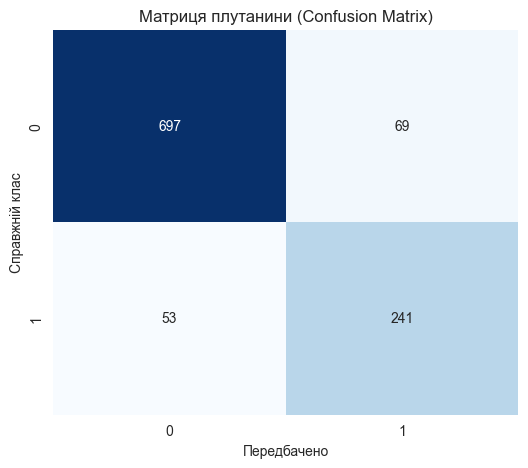

In [14]:
#Невелика візуалізація прогнозів на валідаційному датасеті
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Матриця плутанини (Confusion Matrix)')
plt.xlabel('Передбачено')
plt.ylabel('Справжній клас')
plt.show()